## Imports

In [1]:
from torchvision.transforms.v2.functional import to_pil_image
%load_ext autoreload
%autoreload 2

In [2]:
from typing import Literal, Union

import matplotlib.pyplot as plt
import pandas as pd
import torch
import tqdm
from torch import nn
from torch.utils.data import DataLoader
from transformers import AutoImageProcessor, AutoModelForImageClassification

import data
import lib

from lib import predict_siglip

import ipywidgets as widgets
from IPython.display import display

## Model instantiation

In [3]:
restore_from_checkpoint: Union[int, bool] = 12

model_id = "google/siglip2-large-patch16-384"  # FixRes вариант
model_preprocessor = AutoImageProcessor.from_pretrained(model_id)  # даст resize/normalize, mean/std/size

optimizer = None

# upcoming training epoch
epoch = 0

if restore_from_checkpoint == True or isinstance(restore_from_checkpoint, int):
    if restore_from_checkpoint == True:
        epochs = lib.model_checkpoints(f'./models_siglip2/checkpoint_*.pth')

        if len(epochs) == 0:
            print('no models found')
            raise ValueError('No model found')

        checkpoint_num = epochs[ 0 ]
    else:
        checkpoint_num = restore_from_checkpoint

    print(f'Loading model from epoch { checkpoint_num }')

    checkpoint = torch.load(f'./models_siglip2/checkpoint_{ checkpoint_num }.pth', weights_only=False)

    model = checkpoint['model']
    optimizer = checkpoint['optimizer']

    epoch = model.epoch + 1
else:
    # Веса энкодера + НОВАЯ голова классификации (num_labels=2):
    model = AutoModelForImageClassification.from_pretrained(
        model_id,
        num_labels=len(data.species_labels),
        ignore_mismatched_sizes=True,  # создаст новую голову нужного размера
    )

    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(device)

    model.tracking_loss = []
    model.tracking_loss_val = []
    model.tracking_accuracy = []
    model.tracking_val_probs = []
    # the last epoch we finished training on
    model.epoch = None

tracking_loss = model.tracking_loss
tracking_loss_val = model.tracking_loss_val
tracking_accuracy = model.tracking_accuracy
tracking_val_probs = model.tracking_val_probs

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Loading model from epoch 12


## Training

### Data

In [39]:
train_ds = lib.ImageDatasetSigLip2(data.x_train, data.y_train, processor=model_preprocessor, learning=True)
val_ds   = lib.ImageDatasetSigLip2(data.x_eval, data.y_eval, processor=model_preprocessor, learning=False)

train_loader = DataLoader(train_ds, batch_size=48, shuffle=True, num_workers=6)
val_loader   = DataLoader(val_ds,   batch_size=256, shuffle=False, num_workers=6)

### Optimizer

In [5]:
if optimizer is None:
    optimizer = torch.optim.AdamW()

### Freezing

In [6]:
unfreezing: Literal['classifier_only', 'classifier_and_encoder', 'all'] = 'classifier_and_encoder'

# C) Параметрические группы с «ступенчатым» LR: у головы LR выше, у энкодера ниже
head_params = []
enc_params  = []

if unfreezing == 'classifier_only':
    # 2) Заморозим всё, кроме головы (линейный пробинг)
    for name, p in model.named_parameters():
        p.requires_grad = "classifier" in name  # у HF-классификаторов голова обычно называется "classifier"

        if "classifier" in name:
            head_params.append(p)

elif unfreezing == 'classifier_and_encoder':
    # A) Сначала всё заморозим
    for p in model.parameters():
        p.requires_grad = False
    for name, p in model.named_parameters():
        if "classifier" in name:
            p.requires_grad = True  # голова остаётся обучаемой
            head_params.append(p)

    # B) Разморозим последние L блоков визуального энкодера
    L = 8  # начните с 2–4; при достаточном VRAM можно 6–8
    layers = model.vision_model.encoder.layers   # ModuleList
    for block in layers[-L:]:
        for p in block.parameters():
            p.requires_grad = True
            enc_params.append(p)
elif unfreezing == 'all':
    for p in model.parameters():
        p.requires_grad = True
else:
    raise ValueError(f"Unknown unfreezing mode: {unfreezing}")

In [7]:
optimizer.param_groups = []

optimizer.add_param_group({'name': "encoder", "params": enc_params,  "lr": 1e-4, "weight_decay": 0.05})
optimizer.add_param_group({'name': "classifier", "params": head_params, "lr": 1e-3, "weight_decay": 0.01})

### Loss (possibly with weights)

In [8]:
# 4) Баланс классов (простой вариант: веса в CrossEntropy по частотам)
# import numpy as np
# counts = np.bincount(train_labels, minlength=2)  # counts[0], counts[1]
# class_weights = torch.tensor((counts.sum() / (2.0 * np.maximum(counts, 1))), dtype=torch.float32, device=device)
# criterion = nn.CrossEntropyLoss(weight=class_weights)

criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

### Cutmix + mixup

In [9]:
from torchvision.transforms import v2

use_cutmix_mixup = True

cutmix = v2.CutMix(num_classes=len(data.species_labels))
mixup = v2.MixUp(num_classes=len(data.species_labels))
cutmix_or_mixup = v2.RandomChoice([cutmix, mixup])

### Loop

In [ ]:
stop_button = widgets.Button(description="Stop")
stop_flag = { 'value' : False }

def on_click(b):
    stop_flag['value'] = True

stop_button.on_click(on_click)
display(stop_button)

num_epochs = 5

for cur_epoch in range(epoch, epoch + num_epochs):
    if stop_flag['value'] == True:
        break

    print(f"Starting epoch {cur_epoch}")

    model.train()

    loss_acc = 0
    count = 0

    for batch in tqdm.tqdm(train_loader, total=len(train_loader), desc='Training'):
        optimizer.zero_grad(set_to_none=True)

        images, labels = batch["pixel_values"].to(torch.device("cuda")), batch["labels"].to(torch.device("cuda"))

        if use_cutmix_mixup:
            images, labels = cutmix_or_mixup(images, labels)

        out = model(images)              # logits: (B, 2)
        loss = criterion(out.logits, labels)

        c = batch['pixel_values'].size(0)
        loss_acc += loss.item() * c
        count += c

        loss.backward()
        optimizer.step()

    tracking_loss.append(loss_acc / count)

    # валидация
    model.eval()

    probs, loss_acc = predict_siglip(
        model, val_loader, accumulate_probs=True, accumulate_loss=True, desc='Validation', columns=data.species_labels, criterion=criterion
    )
    tracking_val_probs.append(probs)
    tracking_loss_val.append(loss_acc)

    eval_predictions = probs.idxmax(axis=1)
    eval_true = data.y_eval.idxmax(axis=1)
    correct = (eval_predictions == eval_true).sum()
    accuracy = correct / len(eval_predictions)
    tracking_accuracy.append(accuracy.item())

    model.epoch = cur_epoch
    lib.save_model(model, optimizer, f"./models_siglip2/checkpoint_{str(cur_epoch).rjust(2, "0")}.pth")

    epoch = cur_epoch + 1


## Training progress

In [10]:
pd.DataFrame({'tracking_loss' : tracking_loss, 'tracking_loss_val' : tracking_loss_val, 'tracking_accuracy' : tracking_accuracy }, index=range(len(tracking_accuracy)))

,tracking_loss,tracking_loss_val,tracking_accuracy
0,1.961292,1.687593,0.469679
1,1.795580,1.631418,0.470588
2,1.743363,1.528110,0.496058
3,1.762257,1.541980,0.470588
4,1.741564,1.487562,0.486355
5,1.705244,1.486066,0.458156
6,1.698780,1.471215,0.517586
7,1.665375,1.432797,0.546089
8,1.699083,1.439405,0.521225
9,1.702406,1.423867,0.540327


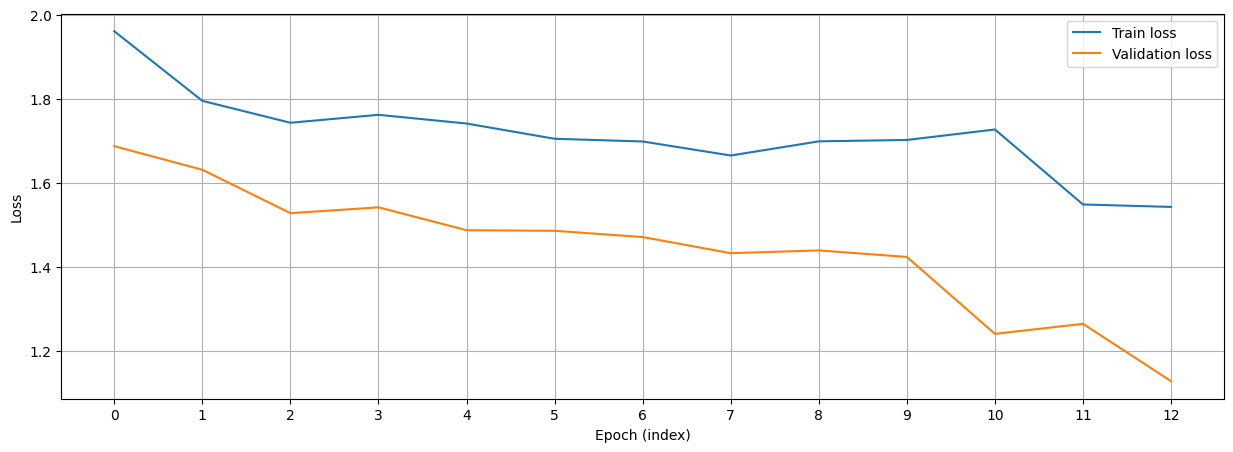

In [11]:
fig, ax = plt.subplots(figsize=(15, 5))

epochs_train = list(range(len(tracking_loss)))
epochs_val = list(range(len(tracking_loss_val)))

line1, = ax.plot(epochs_train, tracking_loss, label="Train loss")
line2, = ax.plot(epochs_val, tracking_loss_val, label="Validation loss")

ax.set_xlabel("Epoch (index)")
ax.set_ylabel("Loss")
ax.legend(loc="best", handles=[line1, line2])

ax.set_xticks(epochs_train)

ax.grid(True)

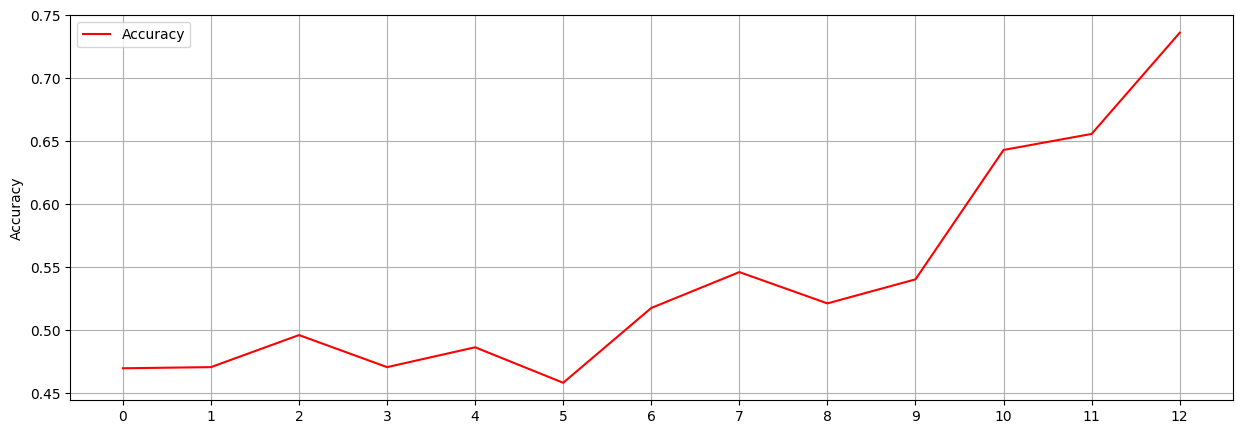

In [12]:
fig, ax = plt.subplots(figsize=(15, 5))

epochs_accuracy = list(range(len(tracking_accuracy)))

line1, = ax.plot(epochs_accuracy, tracking_accuracy, label="Accuracy", color="red")
ax.set_ylabel("Accuracy")

ax.legend(loc="best", handles=[line1])

ax.set_xticks(epochs_train)

ax.grid(True)

## Validation

In [42]:
temp_acc = {}

In [53]:
for key in sorted(temp_acc.keys()):
    print(f'T={key:.5f}: {temp_acc[key]:.5f}')

T=0.68000: 1.11556
T=0.73000: 1.10541
T=0.77000: 1.10174
T=0.78000: 1.10135
T=0.78250: 1.10128
T=0.78500: 1.10122
T=0.79750: 1.10111
T=0.80750: 1.10122
T=0.81000: 1.10128
T=0.82000: 1.10160
T=0.83250: 1.10221
T=0.85750: 1.10412
T=0.87000: 1.10539


In [52]:
import numpy as np

for t in np.arange(0.785, 0.82, 0.0125):
    _, loss = lib.predict_siglip(model, val_loader, accumulate_loss=True, accumulate_probs=False, criterion=criterion, T=t, desc='Searching', columns=data.species_labels)

    print(f"T={t:.5f}: {loss:.4f}")

    temp_acc[t] = loss

Searching: 100%|██████████| 13/13 [01:15<00:00,  5.82s/it]


T=0.785: 1.1012


Searching: 100%|██████████| 13/13 [01:16<00:00,  5.85s/it]


T=0.797: 1.1011


Searching: 100%|██████████| 13/13 [01:16<00:00,  5.86s/it]

T=0.810: 1.1013


In [13]:
eval_preds_df = tracking_val_probs[-1]

eval_preds_df_ten_crop = lib.predict_siglip_ten_crop(model, val_loader, T=1, desc='Predicting', columns=data.species_labels)

Predicting: 100%|██████████| 69/69 [13:50<00:00, 12.03s/it]


In [14]:
eval_preds_df.head()

,antelope_duiker,bird,blank,civet_genet,hog,leopard,monkey_prosimian,rodent
ZJ000000,0.067247,0.746255,0.042348,0.033956,0.016093,0.019350,0.045397,0.029353
ZJ000006,0.057101,0.012795,0.091863,0.666320,0.063716,0.024983,0.024019,0.059204
ZJ000011,0.093184,0.028485,0.212897,0.019793,0.049781,0.337634,0.080077,0.178149
ZJ000023,0.067435,0.010704,0.106893,0.247757,0.027425,0.504294,0.018688,0.016805
ZJ000024,0.021816,0.007942,0.032286,0.004802,0.004425,0.027640,0.891777,0.009311


In [15]:
eval_preds_df_ten_crop.head()

,antelope_duiker,bird,blank,civet_genet,hog,leopard,monkey_prosimian,rodent
ZJ000000,0.181020,0.366353,0.156684,0.020130,0.040482,0.072703,0.113478,0.049149
ZJ000006,0.070564,0.012237,0.218456,0.505476,0.050110,0.024535,0.020996,0.097626
ZJ000011,0.068095,0.049995,0.096729,0.014744,0.055861,0.550942,0.043793,0.119841
ZJ000023,0.102141,0.009816,0.220778,0.111623,0.060889,0.425088,0.028900,0.040767
ZJ000024,0.078558,0.027800,0.220199,0.008840,0.008501,0.039840,0.603047,0.013214


In [16]:
print("True labels (training):")
data.y_train.idxmax(axis=1).value_counts(normalize=True)

True labels (training):


monkey_prosimian    0.172328
blank               0.157544
antelope_duiker     0.151554
rodent              0.123730
leopard             0.116452
bird                0.112585
civet_genet         0.108870
hog                 0.056937
Name: proportion, dtype: float64

In [17]:
print("Predicted labels (eval):")
eval_preds_df.idxmax(axis=1).value_counts(normalize=True)

Predicted labels (eval):


civet_genet         0.275015
leopard             0.152517
antelope_duiker     0.141601
blank               0.128866
monkey_prosimian    0.095209
rodent              0.082777
hog                 0.069133
bird                0.054882
Name: proportion, dtype: float64

In [18]:
print("True labels (eval):")
data.y_eval.idxmax(axis=1).value_counts(normalize=True)

True labels (eval):


civet_genet         0.299272
leopard             0.217708
antelope_duiker     0.144027
rodent              0.115525
hog                 0.068830
monkey_prosimian    0.066404
bird                0.047301
blank               0.040934
Name: proportion, dtype: float64

In [19]:
eval_predictions = eval_preds_df.idxmax(axis=1)
eval_predictions_ten_crop = eval_preds_df_ten_crop.idxmax(axis=1)
eval_true = data.y_eval.idxmax(axis=1)

In [20]:
(eval_predictions_ten_crop != eval_predictions).sum()

np.int64(778)

In [21]:
print(f'Accuracy plain: { (eval_predictions == eval_true).mean() }')
print(f'Accuracy ten crop: { (eval_predictions_ten_crop == eval_true).mean() }')

Accuracy plain: 0.7362037598544573
Accuracy ten crop: 0.6937537901758641


### Predictions vs actual

In [ ]:
eval_preds = eval_preds_df.copy()

eval_preds[ 'cls' ] = eval_preds_df.idxmax(axis=1)
eval_preds[ 'cls_true' ] = data.y_eval.idxmax(axis=1)

eval_preds[(eval_preds[ 'cls' ] == 'blank') & (eval_preds[ 'cls_true' ] == 'leopard')]

In [ ]:
data.species_labels

In [ ]:
import math
from itertools import zip_longest
from PIL import Image
%matplotlib inline
# %matplotlib notebook
# %matplotlib widget
from torchvision.transforms.functional import to_pil_image

random_state = 411111

# rows = eval_preds[(eval_preds[ 'cls' ] == 'blank') & (eval_preds[ 'cls_true' ] == 'leopard')]
rows = eval_preds[(eval_preds[ 'cls' ] == 'leopard') & (eval_preds[ 'cls_true' ] == 'leopard')]

rows = rows.sample(frac=0.02, random_state=random_state)

n_cols = 4
n_rows = math.ceil(len(rows) / n_cols)

fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(18, 15))

# fig.canvas.layout.width = '100%'   # ширину займёт вся ячейка
# Высоту ipywidgets не умеют «auto», укажи соотношение/высоту:
fig.set_figheight(fig.get_figwidth() * 0.6)

invert = v2.RandomInvert(p=1)

# iterate through each species
print(f'Total rows: {len(rows)}')

clahe = lib.LabCLAHE()

for row, ax in zip_longest(list(rows.iterrows()), axes.flatten()):
    if row is None:
        if ax is not None:
            ax.remove()
        continue
    if ax is None:
        break
    img = Image.open('data/train_features/' + row[0] + '.jpg')
    ax.imshow(to_pil_image(clahe(clahe((img)))))
    ax.set_title(f"{row[1].name} ")

fig.tight_layout()

### Confusion matrix

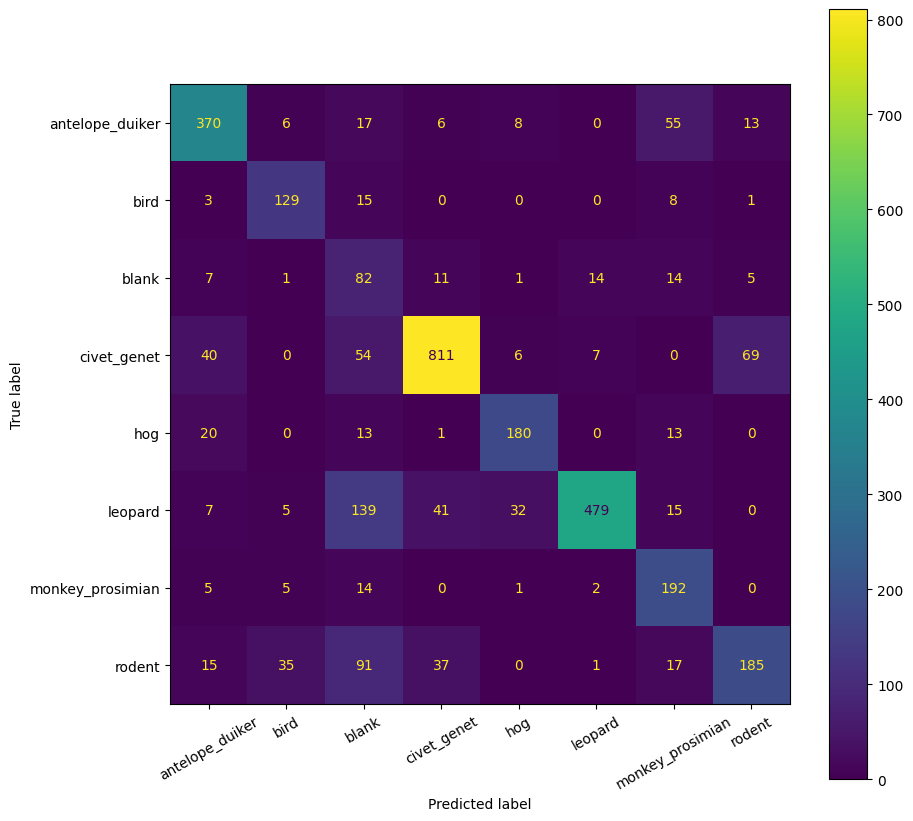

In [22]:
from sklearn.metrics import ConfusionMatrixDisplay

fig, ax = plt.subplots(figsize=(10, 10))
cm = ConfusionMatrixDisplay.from_predictions(
    data.y_eval.idxmax(axis=1),
    eval_preds_df.idxmax(axis=1),
    ax=ax,
    xticks_rotation=30,
    colorbar=True,
)

## Create submission

In [54]:
test_dataset = lib.ImageDatasetSigLip2(data.test_features, processor=model_preprocessor, learning=False)
test_dataloader = DataLoader(test_dataset, batch_size=256, shuffle=False, num_workers=6)

In [55]:
submission_df, _ = predict_siglip(model, test_dataloader, T=0.79750, columns=data.species_labels)

Predicting: 100%|██████████| 18/18 [01:41<00:00,  5.66s/it]


In [56]:
submission_format = pd.read_csv("data/submission_format.csv", index_col="id")

assert all(submission_df.index == submission_format.index)
assert all(submission_df.columns == submission_format.columns)

In [57]:
submission_df.to_csv("submission.csv")

## Create refined data

In [27]:
refined_dataset = lib.ImageDatasetSigLip2(data.train_features, processor=model_preprocessor, learning=False)
refined_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=6)

In [29]:
refined_preds_df, _ = predict_siglip(model, refined_dataloader, columns=data.species_labels)

Predicting:   0%|          | 0/140 [00:01<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
lables_format = pd.read_csv("data/train_labels.csv", index_col="id")

assert all(lables_format.columns == refined_preds_df.columns)

In [ ]:
refined_preds_df.to_csv("data/train_labels_refined.csv")